In [33]:
"""
Funnel Tracking and Advanced Reporting
"""

'\nFunnel Tracking and Advanced Reporting\n'

In [34]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [35]:
# Load Data and Model
# Load the cleaned dataset
df = pd.read_csv('../data/cleaned_sales_leads_dataset.csv')

# Load the saved model
model = joblib.load('../models/best_lead_scoring_model 1.pkl')

# Prepare data for predictions
df_temp = df.drop(columns=['lead_id'])
df_encoded = pd.get_dummies(df_temp, drop_first=True)

X = df_encoded.drop('converted', axis=1)
y_actual = df_encoded['converted']

print(f"Loaded {len(df)} leads for analysis")
print(f"Model: Decision Tree Classifier")

Loaded 1000 leads for analysis
Model: Decision Tree Classifier


In [36]:
# Advanced Lead Scoring with Multiple Factors

# Get prediction probabilities
probabilities = model.predict_proba(X)[:, 1]
df['conversion_probability'] = (probabilities * 100).round(2)

# Create a composite score considering multiple factors
def calculate_composite_score(row):
    """
    Calculate a weighted composite score based on:
    - Model prediction (50%)
    - Engagement score (25%)
    - Budget/Revenue ratio (15%)
    - Contact level (10%)
    """
    # Model score (0-100)
    model_score = row['conversion_probability']
    
    # Engagement score (already 0-100)
    engagement = row['engagement_score']
    
    # Budget score (normalized)
    budget_ratio = min((row['budget_indicated_lkr'] / row['annual_revenue_lkr']) * 100, 100)
    
    # Contact level score
    contact_scores = {'C-Level': 100, 'Manager': 75, 'Employee': 50}
    contact_score = contact_scores.get(row['contact_level'], 50)
    
    # Weighted composite
    composite = (
        model_score * 0.50 +
        engagement * 0.25 +
        budget_ratio * 0.15 +
        contact_score * 0.10
    )
    
    return round(composite, 2)

df['composite_score'] = df.apply(calculate_composite_score, axis=1)

# Prioritization based on composite score
def prioritize_lead(score):
    if score >= 75:
        return 'High'
    elif score >= 50:
        return 'Medium'
    else:
        return 'Low'

df['priority_level'] = df['composite_score'].apply(prioritize_lead)

print("Enhanced lead scoring completed!")
print(f"\nScore Distribution:")
print(df['composite_score'].describe())

Enhanced lead scoring completed!

Score Distribution:
count    1000.000000
mean       62.002190
std        19.063845
min        12.420000
25%        47.480000
50%        68.575000
75%        77.602500
max        86.090000
Name: composite_score, dtype: float64


In [37]:
# Sales Funnel Stage Assignment

def assign_funnel_stage(row):
    """
    Assign leads to funnel stages based on their characteristics
    """
    if row['converted'] == 1:
        return 'Converted'
    elif row['demo_requested'] == 'Yes':
        return 'Demo/Trial'
    elif row['email_opens'] > 10 or row['website_visits'] > 20:
        return 'Qualified'
    elif row['engagement_score'] > 50:
        return 'Engaged'
    else:
        return 'Prospect'

df['funnel_stage'] = df.apply(assign_funnel_stage, axis=1)

# Count leads in each stage
funnel_summary = df['funnel_stage'].value_counts().reindex(
    ['Prospect', 'Engaged', 'Qualified', 'Demo/Trial', 'Converted'],
    fill_value=0
)

print("Sales Funnel Breakdown:")
print(funnel_summary)
print(f"\nConversion Rate: {(df['converted'].sum() / len(df)) * 100:.2f}%")

Sales Funnel Breakdown:
funnel_stage
Prospect       47
Engaged        11
Qualified      93
Demo/Trial     31
Converted     818
Name: count, dtype: int64

Conversion Rate: 81.80%


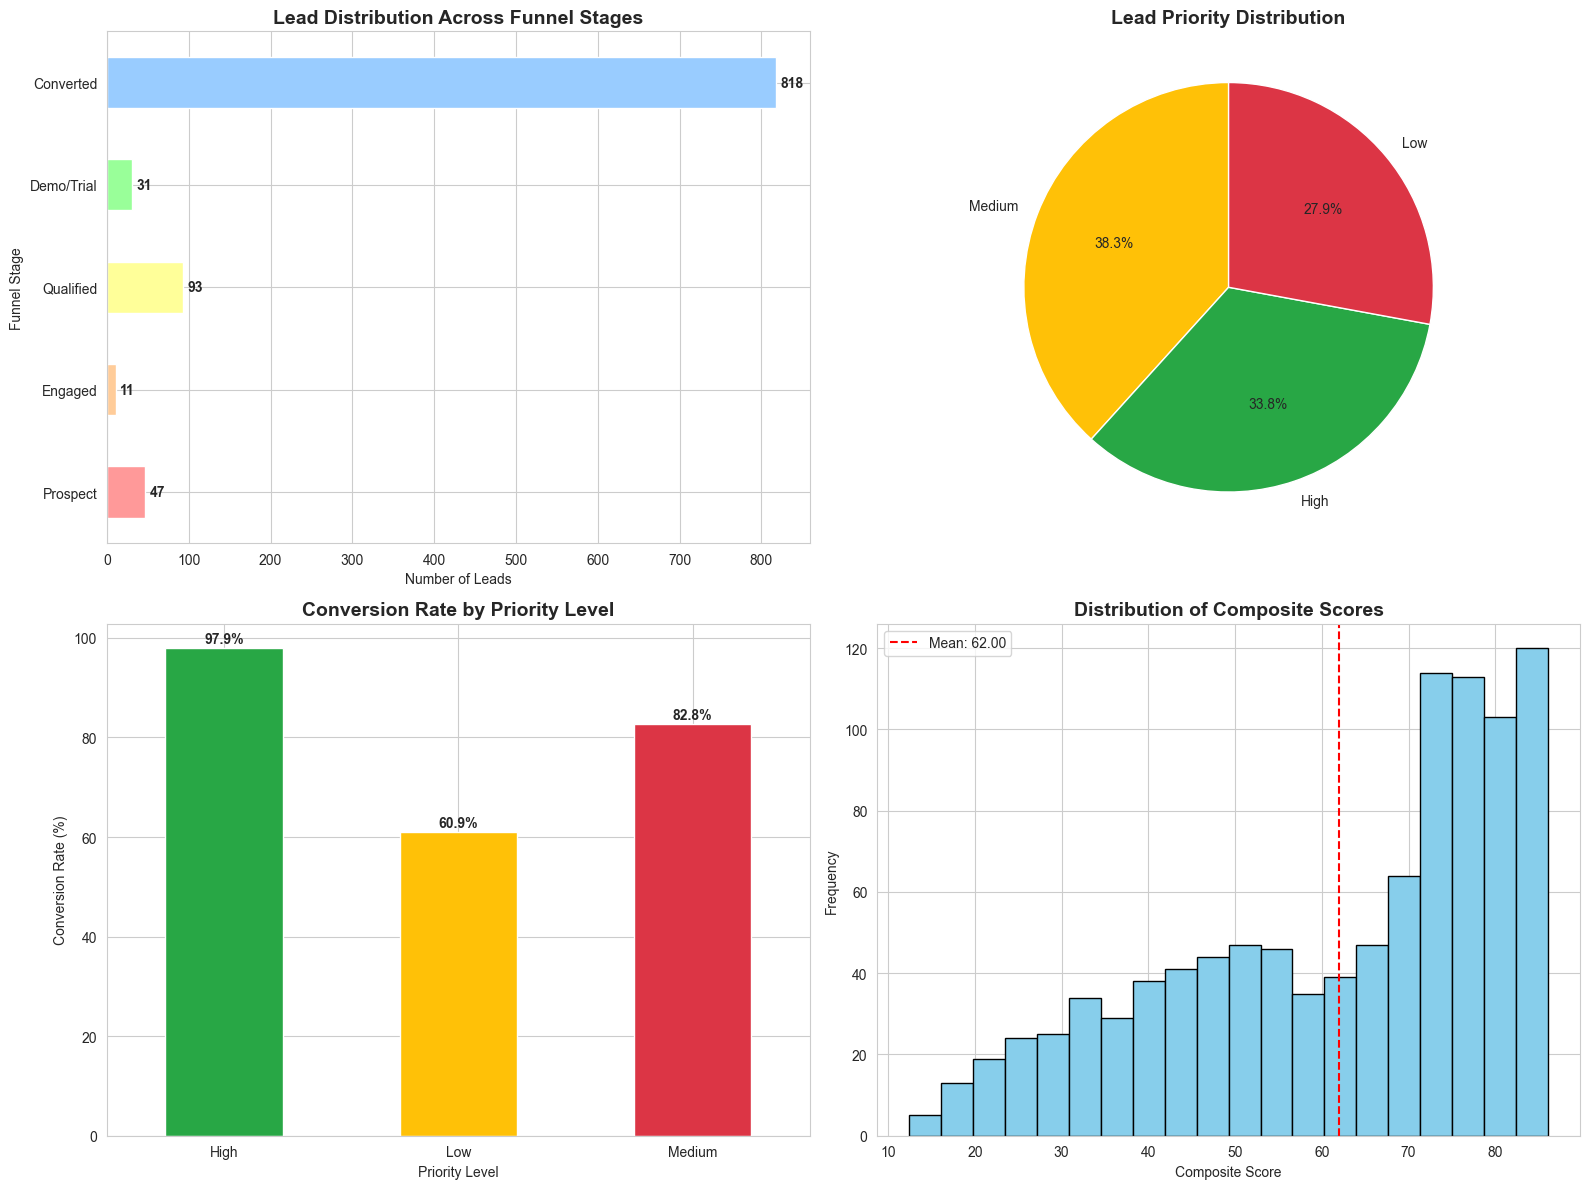

Funnel visualization saved to 'reports' as 'sales_funnel_visualization.png'


In [38]:
# Visualize Complete Sales Funnel

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Funnel Stages
ax1 = axes[0, 0]
funnel_summary.plot(kind='barh', ax=ax1, color=['#ff9999', '#ffcc99', '#ffff99', '#99ff99', '#99ccff'])
ax1.set_title('Lead Distribution Across Funnel Stages', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Leads')
ax1.set_ylabel('Funnel Stage')
for i, v in enumerate(funnel_summary):
    ax1.text(v + 5, i, str(v), va='center', fontweight='bold')

# 2. Priority Distribution
ax2 = axes[0, 1]
priority_counts = df['priority_level'].value_counts()
colors_priority = {'High': '#28a745', 'Medium': '#ffc107', 'Low': '#dc3545'}
ax2.pie(priority_counts, labels=priority_counts.index, autopct='%1.1f%%', 
        colors=[colors_priority[x] for x in priority_counts.index],
        startangle=90)
ax2.set_title('Lead Priority Distribution', fontsize=14, fontweight='bold')

# 3. Conversion Rate by Priority
ax3 = axes[1, 0]
conversion_by_priority = df.groupby('priority_level')['converted'].mean() * 100
conversion_by_priority.plot(kind='bar', ax=ax3, color=['#28a745', '#ffc107', '#dc3545'])
ax3.set_title('Conversion Rate by Priority Level', fontsize=14, fontweight='bold')
ax3.set_xlabel('Priority Level')
ax3.set_ylabel('Conversion Rate (%)')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
for i, v in enumerate(conversion_by_priority):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Score Distribution
ax4 = axes[1, 1]
df['composite_score'].hist(bins=20, ax=ax4, color='skyblue', edgecolor='black')
ax4.set_title('Distribution of Composite Scores', fontsize=14, fontweight='bold')
ax4.set_xlabel('Composite Score')
ax4.set_ylabel('Frequency')
ax4.axvline(df['composite_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["composite_score"].mean():.2f}')
ax4.legend()

plt.tight_layout()
plt.savefig('../reports/sales_funnel_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Funnel visualization saved to 'reports' as 'sales_funnel_visualization.png'")

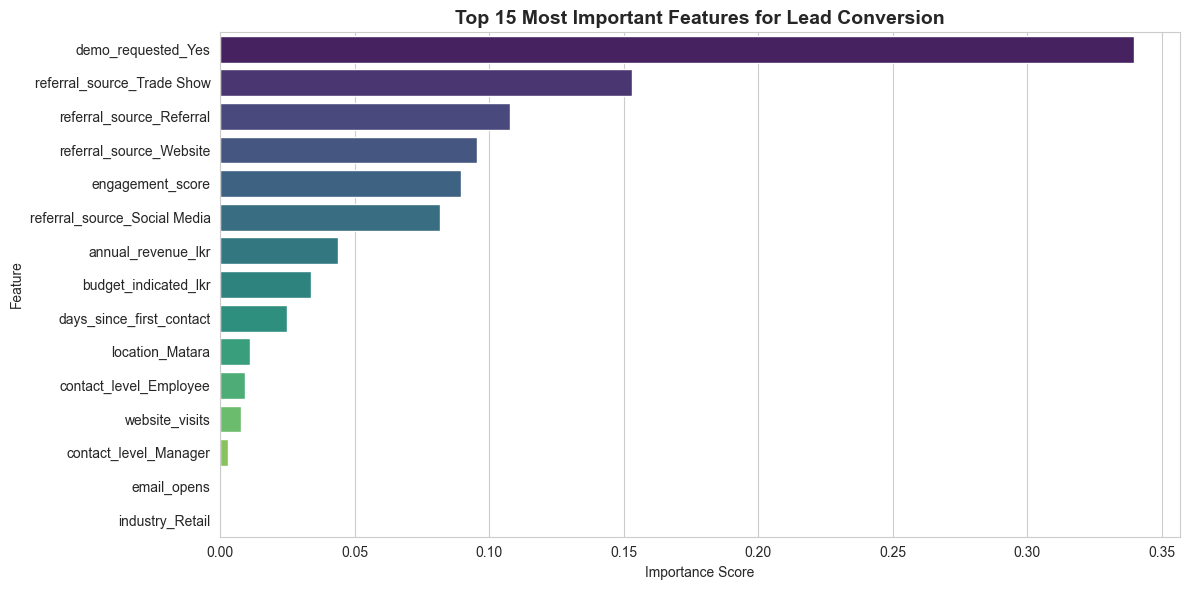


Top 10 Important Features:
                         feature  importance
22            demo_requested_Yes    0.339724
28    referral_source_Trade Show    0.153066
26      referral_source_Referral    0.107503
29       referral_source_Website    0.095466
1               engagement_score    0.089317
27  referral_source_Social Media    0.081495
0             annual_revenue_lkr    0.043756
5           budget_indicated_lkr    0.033892
4       days_since_first_contact    0.024950
20               location_Matara    0.011193


In [39]:
# Feature Importance Analysis

# Get feature importance from the Decision Tree model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features for Lead Conversion', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

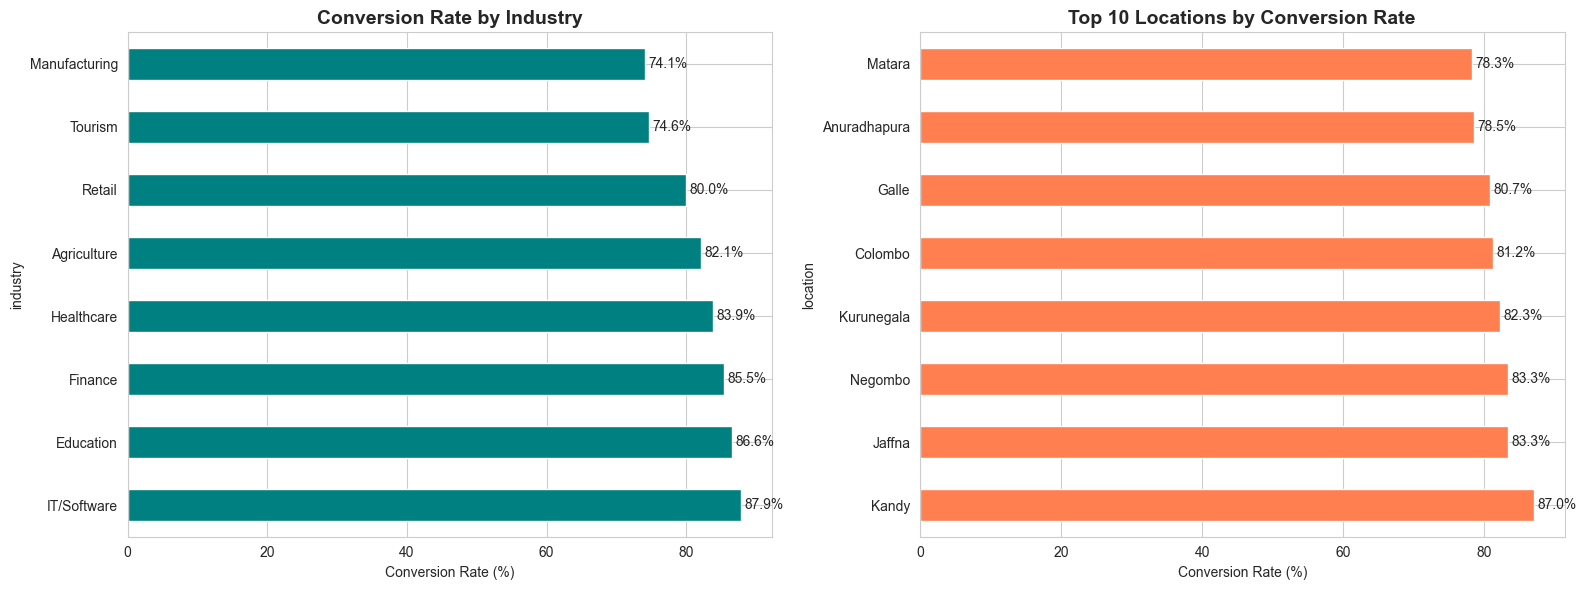

In [40]:
# Industry and Location Analysis

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Conversion rate by industry
ax1 = axes[0]
industry_conv = df.groupby('industry')['converted'].agg(['sum', 'count', 'mean'])
industry_conv['conversion_rate'] = industry_conv['mean'] * 100
industry_conv = industry_conv.sort_values('conversion_rate', ascending=False)
industry_conv['conversion_rate'].plot(kind='barh', ax=ax1, color='teal')
ax1.set_title('Conversion Rate by Industry', fontsize=14, fontweight='bold')
ax1.set_xlabel('Conversion Rate (%)')
for i, v in enumerate(industry_conv['conversion_rate']):
    ax1.text(v + 0.5, i, f'{v:.1f}%', va='center')

# Conversion rate by location
ax2 = axes[1]
location_conv = df.groupby('location')['converted'].agg(['sum', 'count', 'mean'])
location_conv['conversion_rate'] = location_conv['mean'] * 100
location_conv = location_conv.sort_values('conversion_rate', ascending=False).head(10)
location_conv['conversion_rate'].plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Top 10 Locations by Conversion Rate', fontsize=14, fontweight='bold')
ax2.set_xlabel('Conversion Rate (%)')
for i, v in enumerate(location_conv['conversion_rate']):
    ax2.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.savefig('../reports/industry_location_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Generate Comprehensive Lead Report

# Select top priority leads for sales team
high_priority_leads = df[df['priority_level'] == 'High'].sort_values('composite_score', ascending=False)

# Create detailed report
lead_report = df[['lead_id', 'company_size', 'industry', 'location', 'annual_revenue_lkr',
                  'engagement_score', 'contact_level', 'demo_requested', 
                  'conversion_probability', 'composite_score', 'priority_level', 
                  'funnel_stage']].copy()

# Add recommendations
def generate_recommendation(row):
    if row['priority_level'] == 'High':
        if row['demo_requested'] == 'Yes':
            return 'URGENT: Follow up on demo request immediately'
        elif row['contact_level'] == 'C-Level':
            return 'HIGH VALUE: Schedule executive meeting'
        else:
            return 'PRIORITY: Initiate contact within 24 hours'
    elif row['priority_level'] == 'Medium':
        return 'Follow up within 3-5 business days'
    else:
        return 'Nurture campaign - email sequence'

lead_report['action_recommendation'] = lead_report.apply(generate_recommendation, axis=1)

# Save comprehensive report
lead_report.to_csv('../reports/comprehensive_lead_report.csv', index=False)
print(f"Comprehensive report saved with {len(lead_report)} leads")

# Display top 10 priority leads
print("\n" + "="*80)
print("TOP 10 PRIORITY LEADS FOR IMMEDIATE ACTION")
print("="*80)
print(high_priority_leads[['lead_id', 'industry', 'composite_score', 'contact_level', 
                           'funnel_stage']].head(10).to_string(index=False))

Comprehensive report saved with 1000 leads

TOP 10 PRIORITY LEADS FOR IMMEDIATE ACTION
  lead_id      industry  composite_score contact_level funnel_stage
LEAD_0182       Finance            86.09       C-Level    Converted
LEAD_0570   Agriculture            86.09       C-Level    Converted
LEAD_0139 Manufacturing            86.04       C-Level    Converted
LEAD_0043       Finance            86.03       C-Level    Converted
LEAD_0064   Agriculture            86.01       C-Level    Converted
LEAD_0023        Retail            85.98       C-Level    Converted
LEAD_0498       Finance            85.91       C-Level    Converted
LEAD_0893    Healthcare            85.87       C-Level    Converted
LEAD_0031     Education            85.85       C-Level    Converted
LEAD_0175       Tourism            85.82       C-Level    Converted


In [42]:
df.columns


Index(['lead_id', 'company_size', 'industry', 'annual_revenue_lkr', 'location',
       'engagement_score', 'website_visits', 'email_opens', 'demo_requested',
       'days_since_first_contact', 'contact_level', 'budget_indicated_lkr',
       'competitor_using', 'referral_source', 'converted',
       'conversion_probability', 'composite_score', 'priority_level',
       'funnel_stage'],
      dtype='object')

In [44]:
# Create recommendations for full dataset
df['action_recommendation'] = df.apply(generate_recommendation, axis=1)


In [45]:
df.columns


Index(['lead_id', 'company_size', 'industry', 'annual_revenue_lkr', 'location',
       'engagement_score', 'website_visits', 'email_opens', 'demo_requested',
       'days_since_first_contact', 'contact_level', 'budget_indicated_lkr',
       'competitor_using', 'referral_source', 'converted',
       'conversion_probability', 'composite_score', 'priority_level',
       'funnel_stage', 'action_recommendation'],
      dtype='object')

In [46]:
# Daily Automated Report Generator

def generate_daily_report():
    """
    Generate automated daily lead quality report
    """
    report_date = datetime.now().strftime('%Y-%m-%d')
    
    # Summary statistics
    summary = {
        'Report Date': report_date,
        'Total Leads': len(df),
        'High Priority': len(df[df['priority_level'] == 'High']),
        'Medium Priority': len(df[df['priority_level'] == 'Medium']),
        'Low Priority': len(df[df['priority_level'] == 'Low']),
        'Converted': df['converted'].sum(),
        'Conversion Rate': f"{(df['converted'].sum() / len(df)) * 100:.2f}%",
        'Avg Composite Score': f"{df['composite_score'].mean():.2f}",
        'Demos Requested': len(df[df['demo_requested'] == 'Yes']),
        'C-Level Contacts': len(df[df['contact_level'] == 'C-Level'])
    }
    
    # Create summary DataFrame
    summary_df = pd.DataFrame([summary])
    
    # Save reports
    summary_df.to_csv(f'../reports/daily_summary_{report_date}.csv', index=False)
    
    # High priority leads for today
    action_today = df[df['priority_level'] == 'High'].sort_values('composite_score', ascending=False)
    action_today[['lead_id', 'industry', 'composite_score', 'contact_level', 'action_recommendation']].head(20).to_csv(
        f'../reports/action_items_{report_date}.csv', index=False
    )
    
    print(f"Daily reports generated for {report_date}")
    print("\nSummary:")
    for key, value in summary.items():
        print(f"  {key}: {value}")
    
    return summary_df

# Generate the report
daily_summary = generate_daily_report()

Daily reports generated for 2026-01-20

Summary:
  Report Date: 2026-01-20
  Total Leads: 1000
  High Priority: 338
  Medium Priority: 383
  Low Priority: 279
  Converted: 818
  Conversion Rate: 81.80%
  Avg Composite Score: 62.00
  Demos Requested: 394
  C-Level Contacts: 347
